In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import axes
import matplotlib.dates as mdates
from matplotlib import dates
from matplotlib import ticker
from scipy.optimize import curve_fit
from scipy import stats
import seaborn as sns
from ThymeBoost import ThymeBoost as tb
import random
from datetime import datetime, timedelta
import math
from tqdm import tqdm

### Data Loading and Pre-Processing

In [102]:
DIR = "data/"
PATH_CHANNELS_DST = DIR + "df_channels_en.tsv"
PATH_TIME_SERIES_DST = DIR + "df_timeseries_en.tsv"
PATH_COMMENTS_AUTHOR_DST = DIR + "num_comments_authors.tsv.gz"
PATH_COMMENTS_DST = DIR + "num_comments.tsv.gz"
PATH_METADATA_DST = DIR + "yt_metadata_en.jsonl.gz"
PATH_METADATA_HELPER = DIR + "yt_metadata_helper.feather"

In [101]:
timeseries = pd.read_csv(PATH_TIME_SERIES_DST, sep = '\t')
timeseries['datetime']= pd.to_datetime(timeseries['datetime'])
timeseries['delta_views'] = timeseries['delta_views'].round(decimals = 3)
timeseries['subs'] = timeseries['subs'].round(decimals = 3)
timeseries['delta_subs'] = timeseries['delta_subs'].round(decimals = 3)
timeseries.head()

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03,2.024946e+05,0.000,650.222,0.000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,3.940857e+05,191591.111,1046.000,395.778,6,1,1
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17,8.353938e+05,441308.083,1501.500,455.500,6,0,1
3,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-24,1.104577e+06,269183.250,1750.000,248.500,6,0,0
4,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-31,1.284406e+06,179828.600,2008.300,258.300,6,0,0


We filtered the timeseries since data point from before 2017 are corrupt

In [103]:
timeseries_filtered = timeseries[timeseries.datetime > pd.to_datetime("2017-1-1")]
print("We now have {} datapoints".format(len(timeseries_filtered)))

We now have 16732615 datapoints


In [104]:
channel_timeseries = pd.pivot_table(timeseries_filtered, values='delta_views', 
                                index=['datetime'], 
                                columns=['channel'])
print("Without uniformization, we have {} rows.".format(len(channel_timeseries)))
channel_timeseries.head()

Without uniformization, we have 288 rows.


channel,UC--24Q3_ZQeFmgJE-Um5QZQ,UC--2EbuIuBOGgGqPiJxi3rg,UC--3c8RqSfAqYBdDjIG3UNA,UC--3ozenTzry39-xMqAPQlw,UC--6E6EpybocdaNlPhvK_9A,UC--70ql_IxJmhmqXqrkJrWQ,UC--7oyGW0N7fMf164-ZXljQ,UC--94OGFAzYDOJb0eXgMjew,UC--BMyA2X4a9PGAo3lTuopg,UC--EwQJeJ6SKlJdswehQH4g,...,UCzzmGsmy8cBxmqljbVG_e7Q,UCzzoJY_ln_StRVdrRX1_ftg,UCzzqd0yx7h1PuC3KJVqeJgw,UCzzsKg4jPGBL05t2w3HfHBA,UCzzt-UNlRHbEFY3rEpFpuXw,UCzztaOtjmaZoiLvWLagq7bg,UCzzyt9Z70MBX9RQAFVSNlpQ,UCzzzPMh9fZHxc7gxPRB2LHQ,UCzzzUN8yvD2LRAnY-lhzyLQ,UCzzzZ3-icktxbC3j7hkWqRw
datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-01 23:00:00,2731.406,27667.057,NaN,78790.542,45266.219,58624.651,NaN,NaN,230144.542,3141.141,...,1723.201,4365.896,NaN,17874.796,14840.513,NaN,NaN,11938.087,8823.580,57680.059
2017-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,389.792,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-08 23:00:00,4190.594,32073.417,NaN,83433.521,58383.031,261201.391,NaN,NaN,211393.042,3132.073,...,2196.625,2537.089,NaN,21798.781,15995.781,NaN,NaN,16928.234,11129.797,68525.880
2017-01-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,413.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-15 23:00:00,8811.448,60385.818,NaN,176154.271,105656.375,436874.953,NaN,NaN,410550.208,5420.714,...,4063.500,11802.484,NaN,44051.906,24833.911,NaN,NaN,23935.083,17847.375,141159.036


In [6]:
# Project the timestamp to the correct day
uniform_datetime = timeseries_filtered.copy(deep=True)
uniform_datetime.datetime = uniform_datetime.datetime - timedelta(hours = 2)
# Drop the time to only keep the day
uniform_datetime.datetime = pd.to_datetime(uniform_datetime.datetime).dt.date
uniform_channel_timeseries = pd.pivot_table(uniform_datetime, values='delta_views', 
                                index=['datetime'], 
                                columns=['channel'])
print("With uniformization, we have {} rows.".format(len(channel_timeseries)))
uniform_channel_timeseries.head()

With uniformization, we have 288 rows.


channel,UC--24Q3_ZQeFmgJE-Um5QZQ,UC--2EbuIuBOGgGqPiJxi3rg,UC--3c8RqSfAqYBdDjIG3UNA,UC--3ozenTzry39-xMqAPQlw,UC--6E6EpybocdaNlPhvK_9A,UC--70ql_IxJmhmqXqrkJrWQ,UC--7oyGW0N7fMf164-ZXljQ,UC--94OGFAzYDOJb0eXgMjew,UC--BMyA2X4a9PGAo3lTuopg,UC--EwQJeJ6SKlJdswehQH4g,...,UCzzmGsmy8cBxmqljbVG_e7Q,UCzzoJY_ln_StRVdrRX1_ftg,UCzzqd0yx7h1PuC3KJVqeJgw,UCzzsKg4jPGBL05t2w3HfHBA,UCzzt-UNlRHbEFY3rEpFpuXw,UCzztaOtjmaZoiLvWLagq7bg,UCzzyt9Z70MBX9RQAFVSNlpQ,UCzzzPMh9fZHxc7gxPRB2LHQ,UCzzzUN8yvD2LRAnY-lhzyLQ,UCzzzZ3-icktxbC3j7hkWqRw
datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2731.406,27667.057,NaN,78790.542,45266.219,58624.651,NaN,NaN,230144.542,3141.141,...,1723.201,4365.896,389.792,17874.796,14840.513,NaN,NaN,11938.087,8823.580,57680.059
2017-01-08,4190.594,32073.417,NaN,83433.521,58383.031,261201.391,NaN,NaN,211393.042,3132.073,...,2196.625,2537.089,413.875,21798.781,15995.781,NaN,NaN,16928.234,11129.797,68525.880
2017-01-15,8811.448,60385.818,NaN,176154.271,105656.375,436874.953,NaN,NaN,410550.208,5420.714,...,4063.500,11802.484,1117.375,44051.906,24833.911,NaN,NaN,23935.083,17847.375,141159.036
2017-01-22,4207.583,31155.448,NaN,170651.932,118148.547,237834.172,NaN,NaN,351185.609,4501.188,...,1467.172,18982.250,0.000,40054.531,20701.083,NaN,NaN,28294.255,8019.599,89166.245
2017-01-29,0.000,0.000,NaN,0.000,0.000,0.000,NaN,NaN,0.000,0.000,...,0.000,0.000,97.125,0.000,0.000,NaN,NaN,0.000,1184.635,0.000


In [7]:
timeseries_sizes = uniform_channel_timeseries.count().to_frame()

big_timeseries_sizes = timeseries_sizes[timeseries_sizes.values >= 142]
long_timeseries = timeseries[timeseries['channel'].isin(big_timeseries_sizes.index)]
print(len(long_timeseries))
long_timeseries.head()

14947209


,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
117,UCXhkGgooXHDNwgJXmoTSN7g,Music,2016-03-21 00:00:00,1.407062e+07,16179.750,6443.250,0.000,832,0,1
118,UCXhkGgooXHDNwgJXmoTSN7g,Music,2016-03-28 01:00:00,1.412790e+07,57276.576,6480.037,36.787,832,0,1
119,UCXhkGgooXHDNwgJXmoTSN7g,Music,2016-04-04 01:00:00,1.423378e+07,105880.357,6508.156,28.119,832,0,0
120,UCXhkGgooXHDNwgJXmoTSN7g,Music,2016-04-11 01:00:00,1.430530e+07,71514.625,6534.406,26.250,832,0,0
121,UCXhkGgooXHDNwgJXmoTSN7g,Music,2016-04-18 01:00:00,1.434464e+07,39347.281,6571.229,36.823,832,0,0


In [11]:
long_timeseries_norm = long_timeseries.copy()
long_timeseries_norm['delta_views'] = long_timeseries.groupby('channel')['delta_views'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

Slope sort is of the form (channel_name, regression slope, intercept)

In [12]:
# slopes_sort = sorted(slopes, key=lambda x: x[1])

In [13]:
boosted_model = tb.ThymeBoost()
slope_with_outliers = []
slope_without_outliers = []
N = len(long_timeseries_norm['channel'].unique())
for name, channel_df in tqdm(long_timeseries_norm.groupby('channel')):
    output = boosted_model.detect_outliers(channel_df['delta_views'],
                                        trend_estimator='linear',
                                        seasonal_estimator='fourier',
                                        global_cost='maicc',
                                        fit_type='global')
    
    slope = output.yhat.iloc[1] - output.yhat.iloc[0]
    slope_with_outliers.append((name, slope, output.yhat.iloc[0]))

    df = channel_df['delta_views'].copy()
    df[output.outliers] = output[output.outliers].yhat

    output_without_outlier = boosted_model.detect_outliers(df,
                                        trend_estimator='linear',
                                        seasonal_estimator='fourier',
                                        global_cost='maicc',
                                        fit_type='global')

    slope = output_without_outlier.yhat.iloc[1] - output_without_outlier.yhat.iloc[0]
    slope_without_outliers.append((name, slope, output_without_outlier.yhat.iloc[0]))

100%|██████████| 89411/89411 [07:41<00:00, 193.61it/s]


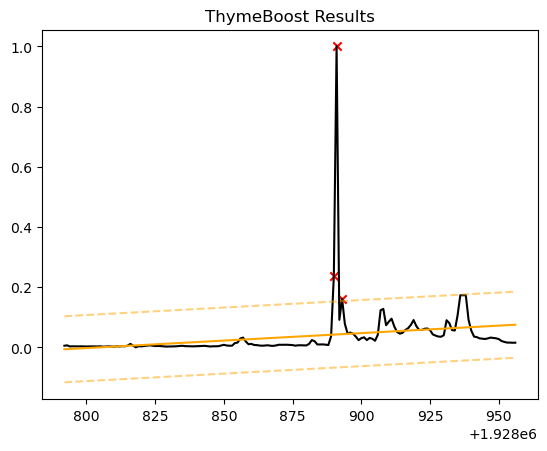

Slope with outlier    0.000497094582023995
Slope without outlier 0.00043930975948265963


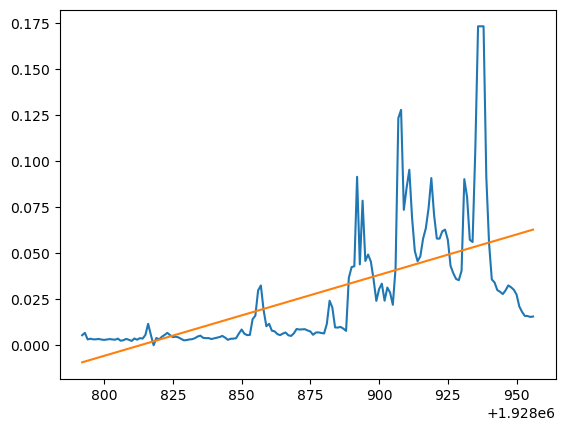

In [14]:
boosted_model = tb.ThymeBoost()
for name, channel_df in long_timeseries_norm.groupby('channel'):
    output = boosted_model.detect_outliers(channel_df['delta_views'],
                                        trend_estimator='linear',
                                        seasonal_estimator='fourier',
                                        global_cost='maicc',
                                        fit_type='global')

    df = channel_df['delta_views'].copy()
    df[output.outliers] = output[output.outliers].yhat

    output_without_outlier = boosted_model.detect_outliers(df,
                                        trend_estimator='linear',
                                        seasonal_estimator='fourier',
                                        global_cost='maicc',
                                        fit_type='global')

    slope = output.yhat.iloc[1] - output.yhat.iloc[0]
    slope2 = output_without_outlier.yhat.iloc[1] - output_without_outlier.yhat.iloc[0]
    break

boosted_model.plot_results(output)
print("Slope with outlier   ", slope)
print("Slope without outlier", slope2)
plt.plot(output_without_outlier.y)
plt.plot(output_without_outlier.yhat)

In [25]:
dict_slope_with_outliers = {}
for el in slope_with_outliers:
    dict_slope_with_outliers[el[0]] = {"slope": el[1], "intercept": el[2]}
    
dict_slope_without_outliers = {}
for el in slope_without_outliers:
    dict_slope_without_outliers[el[0]] = {"slope": el[1], "intercept": el[2]}

diff_slopes = {}
for name in dict_slope_with_outliers:
    diff_slopes[name] = abs(dict_slope_with_outliers[name]["slope"] - dict_slope_without_outliers[name]["slope"])

In [87]:
# random.seed(10)

def sample_from_dict(d, sample=100):
    keys = random.sample(list(d), sample)
    values = [d[k] for k in keys]
    return dict(zip(keys, values))

In [98]:
mean = 0
for i in range(100):
    sample_diff_slopes = sample_from_dict(diff_slopes)
    # sample_dict_slope_with_outliers = {key: dict_slope_with_outliers[key]['slope'] for key in list(sample_diff_slopes.keys())}
    # sample_dict_slope_without_outliers = {key: dict_slope_without_outliers[key]['slope'] for key in list(sample_diff_slopes.keys())}

    sample_diff_slopes_df = pd.DataFrame.from_dict(sample_diff_slopes, orient='index', columns=['slopes'])
    # sample_slope_with_outliers_df = pd.DataFrame.from_dict(sample_dict_slope_with_outliers, orient='index', columns=['slopes'])
    # sample_slope_without_outliers_df = pd.DataFrame.from_dict(sample_dict_slope_without_outliers, orient='index', columns=['slopes'])
    # print(sample_diff_slopes_df.slopes.values().sort_values())
    # break
    mean += sample_diff_slopes_df.slopes.sort_values() / 100
    print(mean)
    break
    plt.plot(range(len(sample_diff_slopes_df.index)), sample_diff_slopes_df.slopes.sort_values(), alpha=0.1)
# mean = np.sum(mean, axis=1)
# plt.plot(range(len(sample_diff_slopes_df.index)), mean)
plt.show()

UCVYkbbrXEVCGiwOQ3iCC1Gw    4.630266e-08
UC-s_hG_sI02u_4k0-sOdt-w    6.277736e-08
UCaWtZ8jphCWKcbS5QwkkIfA    9.048443e-08
UCAXJJ2UhfHFfO5oDBtAlq-A    1.363599e-07
UC7VX20vjDaji94PC3GCv2qA    2.371052e-07
                                ...     
UCsL8rc7RZxR5_d5Bm5L6ivQ    5.900377e-06
UCn6sN4bKlFUF0YXNbdea7hQ    5.918894e-06
UCPBjgYgcGXJQtxt46qsXREA    6.802704e-06
UCw00qFF3snXN_QbBYNIWkpw    7.086386e-06
UCF-usPD55jS0Dg1Af--SDmQ    1.136326e-05
Name: slopes, Length: 100, dtype: float64


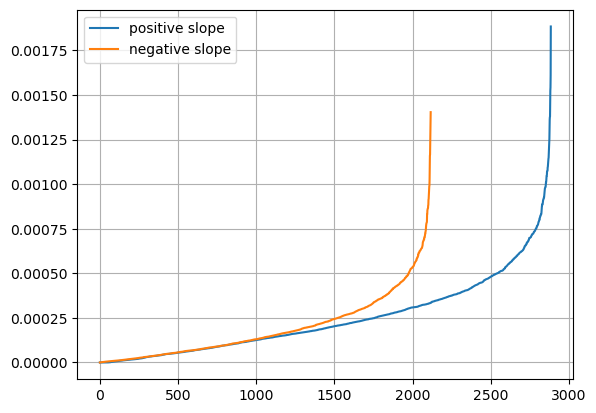

In [80]:
sample_diff_slopes = sample_from_dict(diff_slopes)
sample_dict_slope_with_outliers = {key: dict_slope_with_outliers[key]['slope'] for key in list(sample_diff_slopes.keys())}
sample_dict_slope_without_outliers = {key: dict_slope_without_outliers[key]['slope'] for key in list(sample_diff_slopes.keys())}

sample_diff_slopes_df = pd.DataFrame.from_dict(sample_diff_slopes, orient='index', columns=['slopes'])
sample_slope_with_outliers_df = pd.DataFrame.from_dict(sample_dict_slope_with_outliers, orient='index', columns=['slopes'])
sample_slope_without_outliers_df = pd.DataFrame.from_dict(sample_dict_slope_without_outliers, orient='index', columns=['slopes'])

s = sample_slope_with_outliers_df[sample_slope_with_outliers_df.slopes >= 0]
# plt.scatter(range(len(s)), s.slopes)
# t = sample_slope_without_outliers_df[sample_slope_without_outliers_df.slopes >= 0]
# plt.scatter(range(len(t)), t.slopes)
u = sample_diff_slopes_df[sample_diff_slopes_df.index.isin(s.index)]
plt.plot(range(len(u)), u.slopes.sort_values(), label="positive slope")

t = sample_slope_with_outliers_df[sample_slope_with_outliers_df.slopes < 0]
v = sample_diff_slopes_df[sample_diff_slopes_df.index.isin(t.index)]
plt.plot(range(len(v)), v.slopes.sort_values(), label="negative slope")
plt.legend()
plt.grid()